In [1]:
#import headers
import urllib.request
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import pandas as pd
import numpy as np
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from zipfile import ZipFile
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50

# prepreparing

In [2]:
# load the data
data=pd.read_csv('E:/ass2/cuisine_df.csv')
df = pd.DataFrame()
df['imageID']=data['id']
df['label']=data['cuisine']
print(df['label'].unique())
counts = df['label'].value_counts()
print(counts)
df.head(3)

['French' 'Japanese' 'Italian' 'Chinese' 'Other']
Japanese    1061
Italian      945
Chinese      813
Other        800
French       567
Name: label, dtype: int64


,imageID,label
0,1956014,French
1,2640075,French
2,1955135,Japanese


In [3]:
zip_path = 'E:/ass2/images.zip'  # Path to the images.zip file
unzip_dir ='E:/ass2/images/' # Destination directory for extracting the images
# Open the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    # Extract only the desired images
    for index, row in df.iterrows():
        ID = row['imageID']
        label = row['label']
        image_filename = f'{ID}.jpg'
        label_dir=os.path.join(unzip_dir, str(label))
        os.makedirs(unzip_dir, exist_ok=True)
        zip_ref.extract('images/'+image_filename, path=label_dir)
        extracted_file_path = os.path.join(label_dir, 'images/'+image_filename)
        new_file_path = os.path.join(label_dir,image_filename)
        os.rename(extracted_file_path, new_file_path)       
        
print("Extraction completed successfully.")


Extraction completed successfully.


# data folder

In [3]:
import os
from shutil import copyfile
import pandas as pd
from torchvision.datasets import ImageFolder
image_dir = 'E:/ass2/images'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_dataset = ImageFolder(root=image_dir,transform=transform)

In [4]:
print(image_dataset.classes)

['Chinese', 'French', 'Italian', 'Japanese', 'Other']


In [18]:
# Create DataLoader instances
batch_size = 32
train_size = int(0.7 * len(image_dataset))  # 70% for training
print(train_size)
val_size = len(image_dataset) - train_size  # Remaining 30% for validation
print(val_size)
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print('train_dataset:',len(train_dataset))
print('val_dataset:',len(val_dataset))

2930
1256
train_dataset: 2930
val_dataset: 1256


# model 

In [19]:
# Load the pre-trained ResNet model
resnet = resnet50(pretrained=True)
# Modify the last layer of ResNet for the desired number of classes
num_classes = len(image_dataset.classes)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
# Training and validation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resnet = resnet.to(device)

cuda


In [20]:
#train
num_epochs=20
best_acc=0.0
for epoch in range(num_epochs):
    # Training
    resnet.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        
        images = images.to(device)
       
        labels = labels.to(device)
       
        
        optimizer.zero_grad()
        
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader)
    print('# Validation')
    # Validation
    resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    if val_accuracy>best_acc:
        best_acc=val_accuracy
        savename='./model.pth'
        torch.save(resnet.state_dict(),savename)


# Validation
Epoch 1/20: Train Loss: 1.5919 | Train Acc: 31.23% | Val Loss: 1.6900 | Val Acc: 26.99%
# Validation
Epoch 2/20: Train Loss: 1.4762 | Train Acc: 36.31% | Val Loss: 1.4990 | Val Acc: 35.19%
# Validation
Epoch 3/20: Train Loss: 1.4428 | Train Acc: 37.88% | Val Loss: 1.5020 | Val Acc: 35.99%
# Validation
Epoch 4/20: Train Loss: 1.4246 | Train Acc: 38.70% | Val Loss: 1.7362 | Val Acc: 34.39%
# Validation
Epoch 5/20: Train Loss: 1.4151 | Train Acc: 39.69% | Val Loss: 1.6051 | Val Acc: 37.50%
# Validation
Epoch 6/20: Train Loss: 1.3810 | Train Acc: 41.74% | Val Loss: 1.7002 | Val Acc: 35.43%
# Validation
Epoch 7/20: Train Loss: 1.3601 | Train Acc: 41.95% | Val Loss: 1.5291 | Val Acc: 35.43%
# Validation
Epoch 8/20: Train Loss: 1.3532 | Train Acc: 42.08% | Val Loss: 1.5607 | Val Acc: 36.54%
# Validation
Epoch 9/20: Train Loss: 1.3129 | Train Acc: 44.16% | Val Loss: 1.4319 | Val Acc: 39.97%
# Validation
Epoch 10/20: Train Loss: 1.2637 | Train Acc: 46.69% | Val Loss: 1.5263 | Val A

In [21]:
model=resnet50()
model.fc=torch.nn.Linear(model.fc.in_features,num_classes)
model.load_state_dict(torch.load('./model.pth'))
model=model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Set the model to training mode
model.train()
# Define the number of additional epochs you want to train for
num_additional_epochs = 10
for epoch in range(num_additional_epochs):
    # Training
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)

        correct += predicted.eq(labels).sum().item()
    
    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader)
    model.eval()
    val_loss=0.0
    correct=0
    total=0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    if val_accuracy>best_acc:
        best_acc=val_accuracy
    #savename='./model.pth'
        torch.save(model.state_dict(),'updated_model.pth')
# Save the model after additional training
#torch.save(model, 'updated_model.pth')

Epoch 1: Train Loss: 1.2343 | Train Acc: 47.71% | Val Loss: 1.3986 | Val Acc: 40.84%
Epoch 2: Train Loss: 1.1848 | Train Acc: 49.45% | Val Loss: 1.4019 | Val Acc: 41.64%
Epoch 3: Train Loss: 1.1678 | Train Acc: 50.14% | Val Loss: 1.4060 | Val Acc: 42.60%
Epoch 4: Train Loss: 1.1457 | Train Acc: 51.30% | Val Loss: 1.4421 | Val Acc: 41.08%
Epoch 5: Train Loss: 1.1314 | Train Acc: 52.01% | Val Loss: 1.4259 | Val Acc: 40.13%
Epoch 6: Train Loss: 1.1286 | Train Acc: 52.05% | Val Loss: 1.4381 | Val Acc: 40.92%
Epoch 7: Train Loss: 1.1137 | Train Acc: 52.56% | Val Loss: 1.4854 | Val Acc: 40.68%
Epoch 8: Train Loss: 1.1027 | Train Acc: 53.52% | Val Loss: 1.4658 | Val Acc: 40.61%
Epoch 9: Train Loss: 1.0876 | Train Acc: 54.06% | Val Loss: 1.4508 | Val Acc: 40.29%
Epoch 10: Train Loss: 1.0880 | Train Acc: 54.10% | Val Loss: 1.4974 | Val Acc: 39.89%


# evaluation

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
# ...
# Validation
resnet.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.3989
Precision: 0.3705
Recall: 0.3586
F1 Score: 0.3272


In [28]:
class_to_idx=pd.DataFrame(val_loader.dataset.dataset.class_to_idx.items(),columns=['class','idx'])
class_to_idx

,class,idx
0,Chinese,0
1,French,1
2,Italian,2
3,Japanese,3
4,Other,4


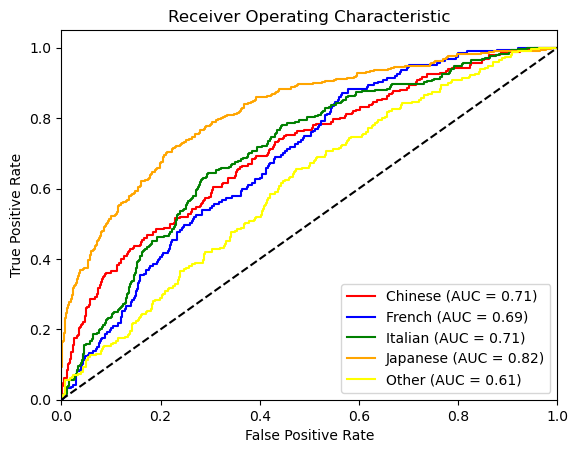

In [29]:
val_probs = []
val_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        val_probs.append(probabilities.cpu().numpy())
        for label in labels:
            val_labels.append(str(label.item()))
val_probs = np.concatenate(val_probs)

val_labels = np.array(val_labels)
# Get unique labels from val_labels
unique_labels=np.unique(val_labels)
#unique_labels = np.unique(val_labels)
# Create label-to-integer mapping

label_mapping = {label: i for i, label in enumerate(unique_labels)}
# Convert string labels to numerical format
val_labels_numeric = np.array([label_mapping[label] for label in val_labels])
# Compute predicted probabilities for each class
# Assuming you have an array of predicted probabilities called val_probs with shape (num_samples, num_classes)
# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = len(label_mapping)
for class_idx in range(num_classes):
    class_labels=(val_labels_numeric == class_idx).astype(int)
    fpr[class_idx], tpr[class_idx], _=roc_curve(class_labels,val_probs[:,class_idx])
    #fpr[class_idx], tpr[class_idx], _ = roc_curve((val_labels_numeric == unique_labels[class_idx]).astype(int), val_probs[:, class_idx])
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])
# Plot ROC curve for each class
plt.figure()
colors = ['red', 'blue', 'green', 'orange','yellow']  # Customize colors for each class
class_labels = list(label_mapping.keys())  # Get the class labels from the mapping
class_labels=unique_labels
for class_idx in range(num_classes):
    plt.plot(fpr[class_idx], tpr[class_idx], color=colors[class_idx], label=class_to_idx['class'][class_idx]+' (AUC = %0.2f)' % (roc_auc[class_idx]))
    #plt.plot(fpr[class_idx], tpr[class_idx], color=colors[class_idx], label='Class %s (AUC = %0.2f)' % (class_labels[class_idx], roc_auc[class_idx]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

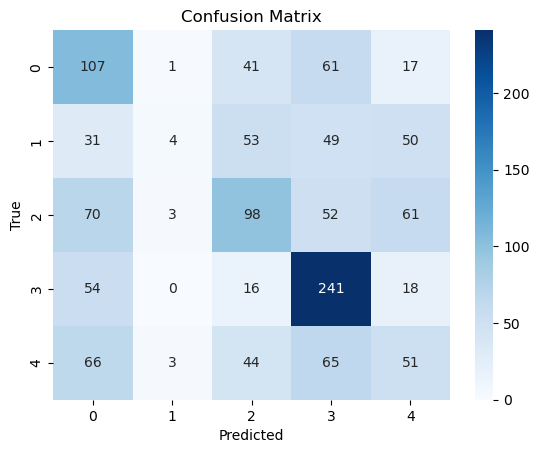

In [51]:
#cm
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(np.array(true_labels),np.array(predicted_labels))
fig,ax=plt.subplots()
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",cbar=True,xticklabels=class_to_idx['class'],yticklabels=)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# prediction

In [40]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_imageJ=Image.open('E:/ass2/sushi.jpg')
input_imageC=Image.open('E:/ass2/Chinese.jpg')
input_tensorJ=transform(input_imageJ)
input_batchJ=input_tensorJ.unsqueeze(0).to(device)
input_tensorC=transform(input_imageC)
input_batchC=input_tensorC.unsqueeze(0).to(device)
with torch.no_grad():
    output=model(input_batchJ)
    _,predictedJ=output.max(1)
predicted_labelJ=predictedJ.item()
with torch.no_grad():
    output=model(input_batchC)
    _,predictedC=output.max(1)
predicted_labelC=predictedC.item()

Text(0.5, 1.0, 'Chinese')

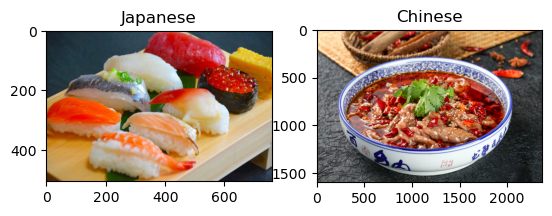

In [42]:
fig,ax=plt.subplots(nrows=1,ncols=2)

ax[0].imshow(input_imageJ)
ax[0].set_title(str(class_to_idx['class'][predicted_labelJ]))
ax[1].imshow(input_imageC)
ax[1].set_title(str(class_to_idx['class'][predicted_labelC]))